# Hyper-parameters selection for random forest


In [19]:
import os
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix

In [6]:
# paths the features
# features
FEATURES_BASE = "../../features/"
FEATURES_DIR = FEATURES_BASE + 'balanced/both/'

# Models
MODELS_DIR = "../../models/"
MODELS_RESULTS = MODELS_DIR + "results/"
NAME = 'full_data_filtered_2s_4000hz_25mfcc_12chroma_1cqt_0rms_1zcr_0sc_0sb_0sr_.npy'

### Load Data


In [20]:
data = np.load(FEATURES_DIR + NAME, allow_pickle=True).item()
X_train = data['train']['X']
y_train = data['train']['y']
X_test = data['test']['X']
y_test = data['test']['y']

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 256, 128, 64, 32), max_iter=200, solver=adam; total time=  20.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 256, 128, 64, 32), max_iter=200, solver=adam; total time=  22.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 256, 128, 64, 32), max_iter=300, solver=adam; total time=  22.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 256, 128, 64, 32), max_iter=200, solver=adam; total time=  24.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 256, 128, 64, 32), max_iter=300, solver=adam; total time=  24.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 256, 128, 64, 32), max_iter=200, solver=adam; total time=  25.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 256, 128, 64, 32), max_iter=200, solver=adam; total time=  26.2s
[CV] END activation=relu, alp

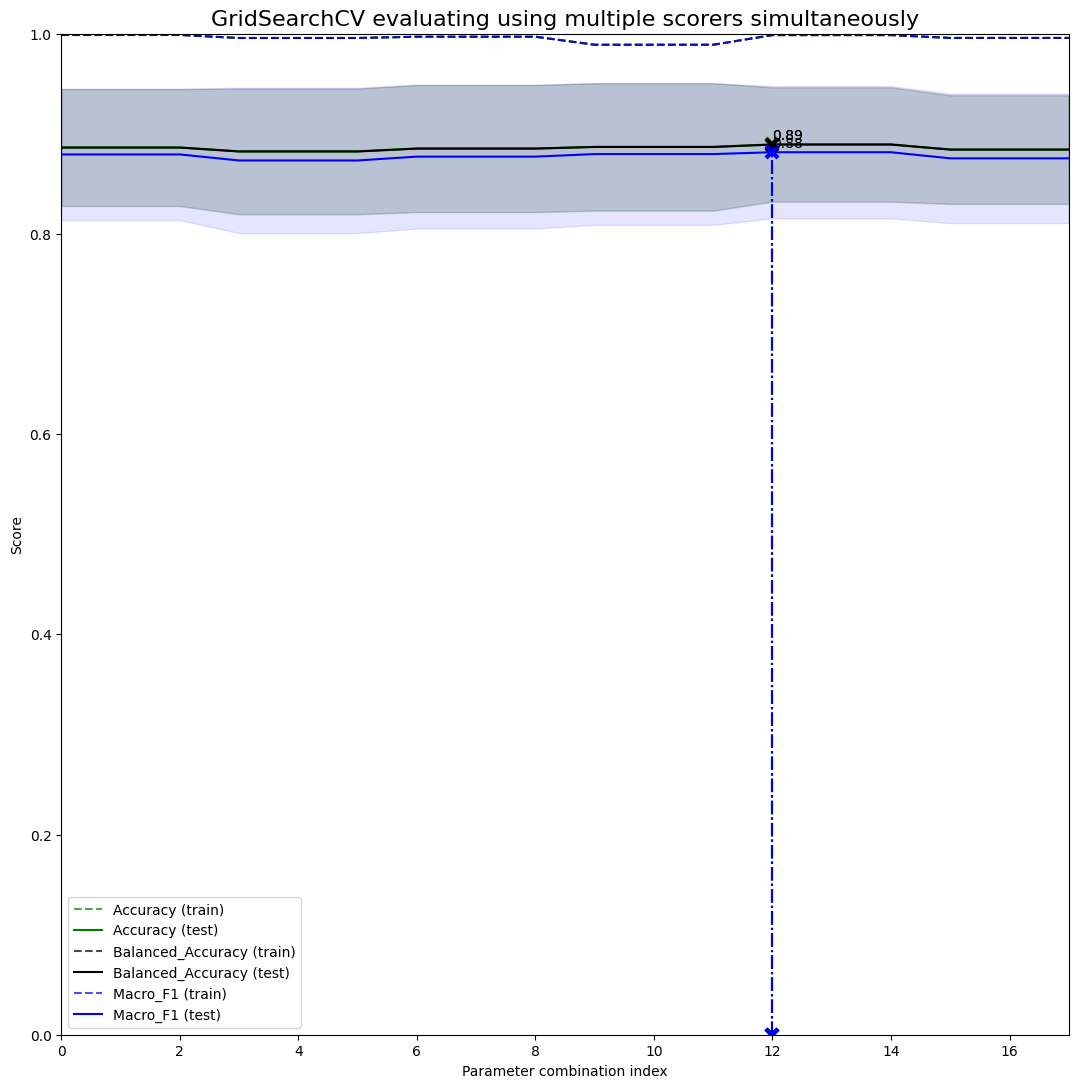

In [25]:
# Define the scoring metrics
scoring = {
    "Accuracy": make_scorer(accuracy_score),
    "Balanced_Accuracy": make_scorer(balanced_accuracy_score),
    "Macro_F1": make_scorer(f1_score, average='macro')
}

param_grid = {
    # 'hidden_layer_sizes': [(40, 100), (100, 40), (64, 128, 256), +(128, 64, 32), (40, 120, 120, 40)], # The number of neurons in each layer
    # 'hidden_layer_sizes': [(128, 64, 32, 16), +(256, 128, 64)], # The number of neurons in each layer
    'hidden_layer_sizes': [(512, 256, 128, 64, 32), (256, 128, 64, 32)], # The number of neurons in each layer
    'activation': ['relu'], # Activation functions
    'solver': ['adam'], # Solvers for weight optimization
    'alpha': [0.0001, 0.001, 0.01], # L2 penalty (regularization term)
    'max_iter': [200, 300, 500] # Maximum number of iterations
}

# Create the GridSearchCV object
gs = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid=param_grid,
    scoring=scoring,
    refit="Macro_F1",
    n_jobs=-1,
    return_train_score=True,
    cv=5,
    verbose=2
)

# Fit the GridSearchCV object
gs.fit(X_train, y_train)
results = gs.cv_results_

# Print the best parameters and the corresponding scores
print("Best parameters found: ", gs.best_params_)
print("Best cross-validation score (Macro F1): ", gs.best_score_)

# Get the classification report for the best model
y_pred = gs.best_estimator_.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plotting the results
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("Parameter combination index")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, len(results['params']) - 1)
ax.set_ylim(0.0, 1.0)

# Get the regular numpy array from the MaskedArray
X_axis = np.arange(len(results['params']))

for scorer, color in zip(sorted(scoring), ["g", "k", "b"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [best_index] * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (best_index, best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()


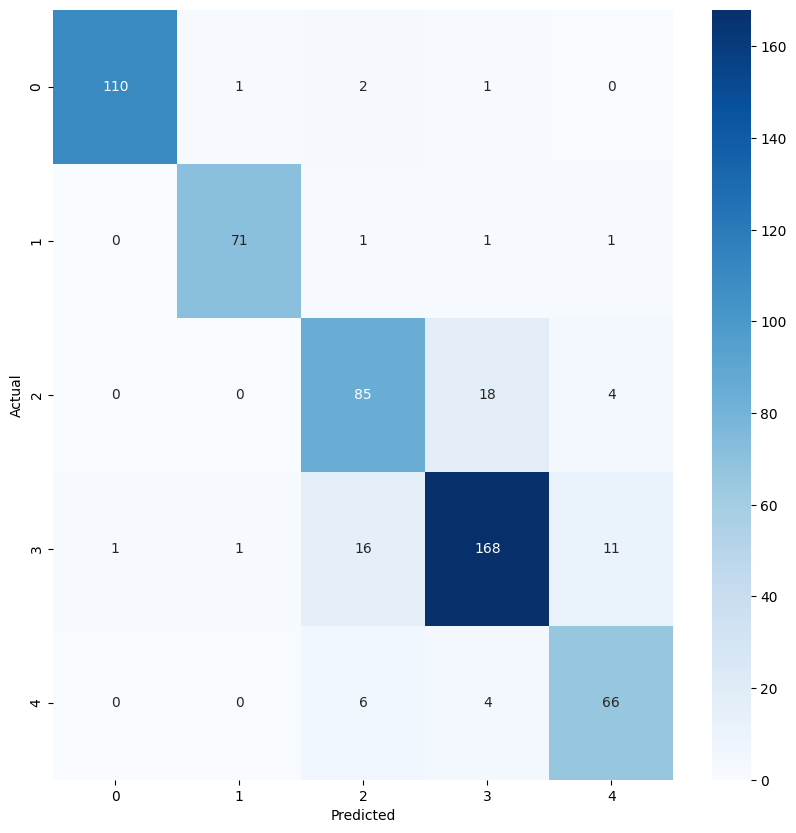

['../../models/MLPClassifier_GS_(512, 256, 128, 64, 32).joblib']

In [26]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the model
MODEL_NAME = "MLPClassifier_GS_(512, 256, 128, 64, 32)"
joblib.dump(gs.best_estimator_, MODELS_DIR + MODEL_NAME + ".joblib")
